In [1]:
import gensim
gensim.__version__

'3.1.0'

In [2]:
import sys

TRAIN_COHESION = False
TOKENIZE = False

corpus_fname= "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/merged_comments.txt"
tokenized_corpus_fname = "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/merged_comments_tokenized.txt"
cohesion_fname = "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/navermovie_cohesion"
maxscore_fname = "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/navermovie_maxscore.pkl"

TRAIN_WORD2VEC = False
word2vec_fname = "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/movie_review_word2vec_model.pkl"

TRAIN_DOC2VEC = False
doc2vec_fname = "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/movie_review_doc2vec_model.pkl"

id2movie_fname = "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/navermovie_info_idx2moviename.pkl"
id2actor_fname = "/home/paulkim/workspace/python/Korean_NLP/data/sample_naver_movie/navermovie_info_idx2actorname.pkl"

## Preprocessing : Cohesion training + Tokenizing
corpus파일은 tab으로 구분하여 한 줄에 <영화아이디, 텍스트, 평점>으로 입력되어 있음

    with open() as f:
        docs = [doc.strip().split('\t') for doc in f]
        
파일을 읽어 한 줄에 줄바꿈 기호를 제거하고, tab으로 줄을 구분함. 결과적으로 한 줄에는 [영화아이디, 텍스트, 평점]의 리스트가 들어있게 됨

    [[영화아이디, 텍스트, 평점],
     [영화아이디, 텍스트, 평점],
     ...
    ]
    
list of list이기 때문에 각각의 column별로 값을 분리하기 위해 zip(\*)을 이용

In [3]:
def get_text(fname):
    with open(fname, encoding='utf-8') as f:
        docs = [doc.strip().split('\t') for doc in f]
        
    idx, texts, scores = zip(*docs)
    return idx, texts, scores

idx, docs, scores = get_text(corpus_fname)
docs[:5]

('명불허전',
 '왠지 고사 피의중간고사보다 재미가없을듯해요 만약보게된다면실망할듯',
 '티아라 사랑해 ㅜ',
 '황정음 윤시윤 지붕킥 인연 김수로 티아라지연 공부의신 인연 너무너무재미있어요',
 '기대 완전')

문서의 길이는3,280,685임. 약 320만개 정도의 리뷰가 존재함

In [4]:
print(docs[:5])
len(docs)

('명불허전', '왠지 고사 피의중간고사보다 재미가없을듯해요 만약보게된다면실망할듯', '티아라 사랑해 ㅜ', '황정음 윤시윤 지붕킥 인연 김수로 티아라지연 공부의신 인연 너무너무재미있어요', '기대 완전')


3280685

In [5]:
print(scores[:5])
len(scores)

('1', '1', '10', '10', '8')


3280685

In [6]:
print(idx[:5])
len(idx)

('72523', '72523', '72523', '72523', '72523')


3280685

TRAIN_COHESION == True이면 cohesion을 학습함. 학습된 결과는
data/sample_naver_movie에 navermovie_cohesion 이름으로 저장함. 만약
TRAIN_COHESION == False이면 학습된 cohesion을 load함

MaxScoreTokenizer에 이용할 scores는 최소 빈도수 10, 최소 cohesion값 0.001 이상인 단어에 대해서만 filtering하여 pickle로 저장함

In [7]:
import pickle
import cohesion_probability as tools

cohesion = tools.CohesionProbability()

if TRAIN_COHESION: 
    cohesion.train(docs)
    cohesion.save(cohesion_fname)
    
    co_scores = cohesion.get_all_cohesion_probabilities()
    co_scores = {word:s[0] for word, s in co_scores.items() if s[2] >= 10 and s[0] > 0.001}
    with open(maxscore_fname, 'wb') as f:
        pickle.dump(co_scores, f)
        
else:
    cohesion.load(cohesion_fname)
    with open(maxscore_fname, 'rb') as f:
        co_scores = pickle.load(f)

Cohesion의 L score 기준으로 토크나이징을 수행하는 MaxScoreToekenizer를 만듦. 만약 TOKENIZE == True이면 모든 문서들을 토크나이징 함. 토크나이징의 예시를 3문자에 대해 수행하고 결과를 확인해봄

In [8]:
co_scores

{'관람객조오오오': 0.21175842918833251,
 '명대사인': 0.14339939359446061,
 '고민해볼': 0.13060929114249678,
 '리메이크하': 0.2714485144953438,
 '관람객재미있는거': 0.25432382593001202,
 '마른': 0.026524849638418332,
 '강요하는거': 0.17761353050806503,
 '정치성향이': 0.14803651120834443,
 'anyw': 0.25362046408365313,
 '대조적이': 0.083891002161255349,
 '한국영화발전의': 0.24012373793422309,
 '바쁘': 0.094065600524776485,
 '슈워': 0.041568155250499346,
 '평점이높다': 0.17404110788809307,
 '대작품': 0.037909792303360099,
 '보기전과': 0.10040630533883017,
 '보기라도': 0.07478080679312378,
 '시간가는지모르고봤어': 0.38718716508166812,
 '꽝이네': 0.26955806566709883,
 '용변신': 0.17546007452710324,
 '엔딩씬에서': 0.30940638941866722,
 '자립': 0.012352662817265742,
 '분당국회의': 0.20967442552926183,
 '영화기도': 0.071221116889213579,
 '뻔하다는게': 0.20934867485341141,
 '저는재미': 0.13723105151148976,
 '예상보단': 0.15367491241298062,
 '낚시다': 0.13120971981879911,
 '이영화는대': 0.11113051965094332,
 '관람객해운': 0.11564567908111502,
 '미아와': 0.065394114201344056,
 '관람객배우들연기력': 0.3107859682432178,
 '재미찾': 0.0265318

In [9]:
from soynlp.tokenizer import MaxScoreTokenizer

tokenizer = MaxScoreTokenizer(scores=co_scores)

for doc in docs[:3]:
    print(doc)
    print(tokenizer.tokenize(doc), '\n')
    
if TOKENIZE:
    with open(tokenized_corpus_fname, 'w', encoding='utf-8') as f:
        for idx_, text, score in zip(idx, docs, scores):
            tokens = ' '.join(tokenizer.tokenize(text)).strip()
            f.write('%s\t%s\t%s\n' % (idx_, tokens, score))
            
    print('tokenizing was done')

명불허전
['명불허전'] 

왠지 고사 피의중간고사보다 재미가없을듯해요 만약보게된다면실망할듯
['왠지', '고사', '피의', '중간', '고사', '보다', '재미', '가', '없을', '듯해요', '만약', '보게', '된다', '면', '실망', '할듯'] 

티아라 사랑해 ㅜ
['티아라', '사랑', '해', 'ㅜ'] 



## Word2Vec 학습
Gensim의 Word2Vec을 학습하기 위해서는 list of str형식의 input이 필요함. 하지만 모든 리뷰들을 메모리에 올리지 않고도 학습할 수 있음. generator인 with open을 이용하여 iter를 오버라이딩한 CommentWord2Vec이라는 클래스를 생성한다

**iter**에서

    for doc in f:
        movie_idx, text, score = doc.split('\t')
        yield text.split()
        
을 수행하면, 파일 f로부터 한 줄을 읽어 tab으로 텍스트를 구분한 뒤, 그 텍스트틀 띄어쓰기 기준으로 잘라낸 token list가 for loop안에서 출력됨

**iter**는 아래 구문이 작동할 수 있도록 해주는 파이썬 내장함수임

    for doc in word2vec_corpus:
        print(doc)
        
토크나이징이 된 리뷰들을 CommentWord2Vec의 fname으로 입력하였기 때문에, 띄어쓰기 만으로 단어열을 yield할 수 있음. 이러한 작업은 반복이 되기 때문에 raw corpus와 tokenized corpus를 구분하여 저장하는 것이 좋음

### 문서 확인작업

In [10]:
with open(tokenized_corpus_fname, encoding='utf-8') as f:
    print(next(f).strip().split('\t'))
    print(next(f).strip().split('\t'))
    print(next(f).strip().split('\t'))
    print("=================")
    for _ in range(3):
        print(next(f).strip().split('\t'))

['72523', '명불허전', '1']
['72523', '왠지 고사 피의 중간 고사 보다 재미 가 없을 듯해요 만약 보게 된다 면 실망 할듯', '1']
['72523', '티아라 사랑 해 ㅜ', '10']
['72523', '황정 음 윤시윤 지붕킥 인연 김수 로 티아라 지연 공부 의신 인연 너무 너무 재미 있어 요', '10']
['72523', '기대 완전', '8']
['72523', '기대 지연 나온다', '10']


## CommentWord2Vec 클래스

In [11]:
import os

class CommentWord2Vec:
    def __init__(self, fname):
        self.fname = fname
        if not os.path.exists(fname):
            print("File not found : %s"%fname)
            
    def __iter__(self):
        with open(self.fname, encoding='utf-8') as f:
            for doc in f:
                movie_idx, text, score = doc.split('\t')
                yield text.split()
                
word2vec_corpus = CommentWord2Vec(tokenized_corpus_fname)

for num_doc, doc in enumerate(word2vec_corpus):
    if num_doc > 5: break
    print(doc)

['명불허전']
['왠지', '고사', '피의', '중간', '고사', '보다', '재미', '가', '없을', '듯해요', '만약', '보게', '된다', '면', '실망', '할듯']
['티아라', '사랑', '해', 'ㅜ']
['황정', '음', '윤시윤', '지붕킥', '인연', '김수', '로', '티아라', '지연', '공부', '의신', '인연', '너무', '너무', '재미', '있어', '요']
['기대', '완전']
['기대', '지연', '나온다']


Gensim의 Word2Vec을 이용함. 미리 만들어둔 word2vec_corpus를 Word2Vec의 argument로 입력함. default parameters를 이용하여 Word2Vec을 학습함

Word2Vec의 arguments 중에서 중요한 것들을 아래와 같음
- size : 단어의 임베딩 공간 크기
- alpha : learngin rate
- window : 한 단어의 좌/우 문맥 크기
- min_count : 모델이 학습할 단어의 최소 출현 빈도수
- max_vocab_size : None이 아닌 숫자를 입력하면 빈도수 기준으로 상위 max_vocab_size갯수 만큼의 단어만 학습
- sg : 1이면 skipgram 사용
- negative : negative sampling에서 negative sample의 갯수

In [14]:
from gensim.models import Word2Vec
import pickle

if True: # TRAIN_WORD2VEC 
    word2vec_model = Word2Vec(word2vec_corpus,
                             size=100,
                             alpha=0.025,
                             window=5,
                             min_count=5,
                             sg=0,
                             negative=5)
    with open(word2vec_fname, 'wb') as f:
        pickle.dump(word2vec_model, f)
        
else:
    with open(word2vec_fname, 'rb') as f:
        word2vec_model = pickle.load(f)

학습된 Word2Vec모델의 .most_similar(단어, topn)함수는 입력된 단어에 대하여 가장 비슷한 topn개의 다른 단어들과 유사도를 출력함

'영화'와 가장 비슷한 단어는 '애니'이며, 유사도는 0.71인 것을 확인할 수 있음

In [15]:
word2vec_model.most_similar('영화', topn=10)

[('애니', 0.7138866186141968),
 ('애니메이션', 0.6852263808250427),
 ('작품', 0.6574145555496216),
 ('여화', 0.6330816745758057),
 ('명화', 0.6184117794036865),
 ('드라마', 0.6060880422592163),
 ('수작', 0.5869717001914978),
 ('블록버스터', 0.5703098773956299),
 ('영호ㅏ', 0.5641317367553711),
 ('영회', 0.5619239807128906)]

In [16]:
word2vec_model.most_similar('하정우', topn=10)

[('송강호', 0.9034820795059204),
 ('공유', 0.8601564168930054),
 ('이정재', 0.8592849969863892),
 ('황정민', 0.8296512365341187),
 ('유아인', 0.8218746185302734),
 ('설경구', 0.8081878423690796),
 ('송광호', 0.8078097701072693),
 ('유해진', 0.8034721612930298),
 ('손현주', 0.8022032976150513),
 ('윌스미스', 0.7958036661148071)]

1점과 유사한 단어가 한글로 쓴 '일점', 그 이후로 1,2,3,... 으로 점수가 멀어지는 것도 확인해볼 수 있음

In [17]:
word2vec_model.most_similar('1점', topn=10)

[('일점', 0.8922281861305237),
 ('별1개', 0.8552322387695312),
 ('별반개', 0.8496533632278442),
 ('2점', 0.836587131023407),
 ('별한개', 0.8320378661155701),
 ('3점', 0.8045069575309753),
 ('4점', 0.7945771217346191),
 ('5점', 0.7926749587059021),
 ('6점', 0.7472018003463745),
 ('반점', 0.7396203279495239)]

'십점'이라는 말은 점수가 들어갈 수 있는 문맥에서 나오는 말이지만, 긍정적인 표현에서 더 많이 나왔을 것으로 생각해 볼 여지가 있음. 그렇기 때문에 1점 보다도, 천점, 백점과 같은 단어들이 더 유사하게 학습되었음

In [18]:
word2vec_model.most_similar('십점', topn=10)

[('백점', 0.8282591104507446),
 ('별다섯개', 0.8000174760818481),
 ('별5개', 0.7892116904258728),
 ('구점', 0.7733089923858643),
 ('일점', 0.7692224383354187),
 ('반점', 0.7493522763252258),
 ('1점', 0.7364986538887024),
 ('별반개', 0.7139477729797363),
 ('만점', 0.7109811305999756),
 ('천점', 0.7097568511962891)]

In [20]:
word2vec_model.most_similar('조재현', topn=10)

[('김해숙', 0.8757877349853516),
 ('곽도원', 0.8685107231140137),
 ('이성민', 0.8624265193939209),
 ('김상경', 0.8570097088813782),
 ('신하균', 0.850275993347168),
 ('감우성', 0.8457485437393188),
 ('이경영', 0.8431169986724854),
 ('김원해', 0.8402273654937744),
 ('변희봉', 0.838852047920227),
 ('정진영', 0.838627815246582)]

평론가는 평론가, 평론 단체(씨네21 등)끼리 뭉쳐 나오는 것을 확인할 수 있음

In [21]:
word2vec_model.most_similar('허지웅', topn=10)

[('진중권', 0.8222264051437378),
 ('황진미', 0.8020687103271484),
 ('이동진', 0.7692365646362305),
 ('박평식', 0.7439994812011719),
 ('김현수', 0.7388884425163269),
 ('이용철', 0.6942434310913086),
 ('송경원', 0.6923471689224243),
 ('정시우', 0.6794375777244568),
 ('허남웅', 0.6765536665916443),
 ('씨네21', 0.6621863842010498)]

In [22]:
word2vec_model.most_similar('평론가', topn=10)

[('전문가', 0.8732424974441528),
 ('기자', 0.8724387288093567),
 ('씨네21', 0.8168579339981079),
 ('한겨레', 0.7687677145004272),
 ('평론가들', 0.7549707889556885),
 ('시네21', 0.723842978477478),
 ('황진미', 0.7185804843902588),
 ('김현수', 0.7158207893371582),
 ('평론', 0.7101935148239136),
 ('일베', 0.7048846483230591)]

In [23]:
word2vec_model.most_similar('평론',  topn=10)

[('비평', 0.8542644381523132),
 ('비난', 0.7665924429893494),
 ('평가', 0.7353394031524658),
 ('악평', 0.7253502607345581),
 ('평론가', 0.7101935148239136),
 ('비방', 0.6874409914016724),
 ('마녀사냥', 0.6871091723442078),
 ('판단', 0.6837940216064453),
 ('씨네21', 0.6804366111755371),
 ('비판', 0.6798620820045471)]

In [24]:
word2vec_model.most_similar('조연', topn=10)

[('조연들', 0.8406175374984741),
 ('주연', 0.704506516456604),
 ('단역', 0.7021804451942444),
 ('조연들의', 0.6993423700332642),
 ('배역', 0.5666938424110413),
 ('배역들', 0.563075840473175),
 ('김성균', 0.5463605523109436),
 ('캐스팅', 0.5423542857170105),
 ('장광', 0.5357850790023804),
 ('정재영', 0.5347440838813782)]

In [25]:
word2vec_model.most_similar('국제시장', topn=10)

[('부산행', 0.8156810998916626),
 ('검사외전', 0.8101078271865845),
 ('명량', 0.8027456998825073),
 ('베를린', 0.7837790250778198),
 ('변호인', 0.7703098654747009),
 ('곡성', 0.7664663791656494),
 ('역린', 0.7645063400268555),
 ('레미제라블', 0.7508106827735901),
 ('고지전', 0.7486091256141663),
 ('7번방의선물', 0.7324813008308411)]

In [26]:
word2vec_model.most_similar('조연', topn=10)

[('조연들', 0.8406175374984741),
 ('주연', 0.704506516456604),
 ('단역', 0.7021804451942444),
 ('조연들의', 0.6993423700332642),
 ('배역', 0.5666938424110413),
 ('배역들', 0.563075840473175),
 ('김성균', 0.5463605523109436),
 ('캐스팅', 0.5423542857170105),
 ('장광', 0.5357850790023804),
 ('정재영', 0.5347440838813782)]

In [27]:
word2vec_model.most_similar('일산', topn=10)

[('용산', 0.9280275702476501),
 ('영등포', 0.9163991808891296),
 ('신도림', 0.8824882507324219),
 ('상암', 0.8808504343032837),
 ('왕십리', 0.8808397054672241),
 ('강변', 0.8796026706695557),
 ('압구정', 0.8722113966941833),
 ('목동', 0.8656615018844604),
 ('수원', 0.8612732887268066),
 ('김포공항', 0.8591942191123962)]

In [30]:
word2vec_model.most_similar('메가박스', topn=25)

[('영등포', 0.8691478371620178),
 ('롯데', 0.8646195530891418),
 ('시네마', 0.860352098941803),
 ('왕십리', 0.8569331169128418),
 ('일산', 0.8473675847053528),
 ('용산', 0.8466935753822327),
 ('동대문', 0.8389988541603088),
 ('부천', 0.835645854473114),
 ('목동', 0.8231019973754883),
 ('씨너스', 0.8216773271560669),
 ('신촌', 0.8188371062278748),
 ('홍대', 0.8187383413314819),
 ('상암', 0.8184813857078552),
 ('센텀', 0.8162912726402283),
 ('m2관', 0.8162129521369934),
 ('강변', 0.8137304186820984),
 ('수원', 0.8134036064147949),
 ('9시', 0.8045904636383057),
 ('6시', 0.8004239797592163),
 ('피카디리', 0.7996371984481812),
 ('롯시', 0.797426700592041),
 ('이벤트로', 0.7937914133071899),
 ('1관', 0.7847319841384888),
 ('울산', 0.7842491865158081),
 ('청량리', 0.7829053401947021)]

In [31]:
word2vec_model.most_similar('ocn', topn=10)

[('OCN', 0.8375531435012817),
 ('케이블', 0.7315939664840698),
 ('설날특집', 0.723868191242218),
 ('특집', 0.7191470265388489),
 ('아맥', 0.7177295684814453),
 ('설특집', 0.7103910446166992),
 ('tv', 0.7049843072891235),
 ('KBS', 0.7024969458580017),
 ('공중파', 0.6966946721076965),
 ('오씨엔', 0.6897567510604858)]

In [32]:
word2vec_model.most_similar('유아인', topn=10)

[('황정민', 0.8707073926925659),
 ('심은경', 0.8525611162185669),
 ('이선균', 0.846018373966217),
 ('조진웅', 0.8388024568557739),
 ('박소담', 0.8365183472633362),
 ('하정우', 0.8218746185302734),
 ('정재영', 0.8217036724090576),
 ('손예진', 0.8125660419464111),
 ('최민식', 0.8113982677459717),
 ('이정재', 0.8101773858070374)]

### Word2Vec.wv.syn0 : 실제 단어가 저장되어 있는 행렬



Word2Vec model의 단어 벡터들은 Word2Vec.wv 아래에 저장되어 있음. gensim version 1.x부터 Word2Vect.wv에서 단어 벡터를 따로 관리함

size=100으로 69423개의 단어를 학습하였기 때문에 sync0의 shape은 아래와 같은 결과를 보여줌

In [33]:
word2vec_model.wv.syn0.shape

(69423, 100)

### Word2Vec.wv.syn0norm : cosine similarity를 위하여 row normalize를 한 행렬로 모양은 같지만, 벡터의 2 Norm이 1임

In [34]:
word2vec_model.wv.syn0norm.shape

(69423, 100)

In [35]:
sum((v**2 for v in word2vec_model.wv.syn0[0]))

322.47118045029379

In [36]:
sum((v**2 for v in word2vec_model.wv.syn0norm[0]))

0.99999990827193619

word2Vec.wv.index2word는 단어별 index가 저장되어 있음

In [37]:
type(word2vec_model.wv.index2word)

list

In [38]:
word2vec_model.wv.index2word[0]

'영화'

단어 벡터를 가져오려면 아래 코드 중 하나를 실행하면 됨

    word2vec_model.wv['영화'] # 2.2부터의 인터페이스
    
    word2vec_model['영화'] # 0.9.x에서의 인터페이스

In [39]:
word2vec_model.wv['영화']

array([-0.63684946, -0.78024042,  0.86479181,  1.69366455, -0.76155227,
        3.38031006, -2.41847825, -2.76606584, -3.31960297,  0.28368351,
       -1.47958016, -1.60667562,  0.43943831, -0.55189162,  2.98871589,
        0.55318564,  1.12546384,  2.20541286,  0.32103914, -2.38163233,
       -1.98183703,  0.88107395,  1.124403  , -3.43959308, -3.02727723,
       -2.58685231, -0.2629233 , -2.10577965, -4.44497442,  1.41801214,
       -0.76266736, -1.13885117,  1.44543254,  1.40969396, -0.27999681,
       -0.29742748,  0.50327009, -0.47987977, -2.25981498,  1.85320652,
       -1.08543158, -0.25273269,  1.33381975,  0.94161826,  0.4095163 ,
       -1.17921793, -5.81125689, -1.43257511, -1.7314136 , -0.02581845,
       -2.19534159, -2.97580051,  0.4248431 ,  2.68781614, -0.17374928,
       -1.48311543, -0.42280477,  0.24020289,  1.89213657,  1.93719375,
        0.02536361,  0.01659036, -1.22091353,  1.29848647,  0.9111954 ,
        1.60217297,  2.3029964 , -1.09346724, -0.70472372, -0.59

In [40]:
word2vec_model['영화']

array([-0.63684946, -0.78024042,  0.86479181,  1.69366455, -0.76155227,
        3.38031006, -2.41847825, -2.76606584, -3.31960297,  0.28368351,
       -1.47958016, -1.60667562,  0.43943831, -0.55189162,  2.98871589,
        0.55318564,  1.12546384,  2.20541286,  0.32103914, -2.38163233,
       -1.98183703,  0.88107395,  1.124403  , -3.43959308, -3.02727723,
       -2.58685231, -0.2629233 , -2.10577965, -4.44497442,  1.41801214,
       -0.76266736, -1.13885117,  1.44543254,  1.40969396, -0.27999681,
       -0.29742748,  0.50327009, -0.47987977, -2.25981498,  1.85320652,
       -1.08543158, -0.25273269,  1.33381975,  0.94161826,  0.4095163 ,
       -1.17921793, -5.81125689, -1.43257511, -1.7314136 , -0.02581845,
       -2.19534159, -2.97580051,  0.4248431 ,  2.68781614, -0.17374928,
       -1.48311543, -0.42280477,  0.24020289,  1.89213657,  1.93719375,
        0.02536361,  0.01659036, -1.22091353,  1.29848647,  0.9111954 ,
        1.60217297,  2.3029964 , -1.09346724, -0.70472372, -0.59

Word2Vec에서 index2word의 단어 순서는 단어의 빈도순임. 단어에 관련된 정보를 가져오고 싶다면 Word2Vec.wv.vocab을 이용하면 됨

vocab은 {단어 : Vocab} 형식의 dict임. Vocab은 namedtuple이기 때문에 아래와 같이 이용할 수 있음

    word2vec_model.wv.vocab['영화'].count

In [41]:
word2vec_model.wv.vocab['영화']

In [42]:
str(word2vec_model.wv.vocab['영화'])

'Vocab(count:1412521, index:0, sample_int:896816219)'

In [43]:
word2vec_model.wv.vocabcab['영화'].count

1412521

영화 다음으로 많이 등장한 단어를 가져와 보자. index는 index2word의 index임

In [44]:
word2vec_model.wv.index2word[1], word2vec_model.wv.index2word[2]

('이', '관람객')

In [45]:
print(str(word2vec_model.wv.vocab['이']))
print(str(word2vec_model.wv.vocab['관람객']))

Vocab(count:762641, index:1, sample_int:1286867673)
Vocab(count:585858, index:2, sample_int:1508478567)


## Doc2Vec학습
Doc2Vec을 학습하기 위해서는 각각 문서의 label이 저장되어야 함. 이를 위하여 TaggedDocument라는 클래스를 이용함. TaggedDocument는 단어들을 words.에, 레이블 정보를 tags에 리스트 형태로 입력함
 - 학습시간 매우 김

In [46]:
import os
import time
import pickle
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

start_time = time.time()
class CommentDoc2Vec:
    def __init__(self, fname):
        self.fname = fname
        if not os.path.exists(fname):
            print("File not found : %s"%fname)
            
    def __iter__(self):
        with open(self.fname, encoding='utf-8') as f:
            for doc in f:
                movie_idx, text, score = doc.split('\t')
                yield TaggedDocument(words=text.split(), tags=['MOVIE_%s'%movie_idx])
                
doc2vec_corpus = CommentDoc2Vec(tokenized_corpus_fname)

if True: # TRAIN_DOC2VEC
    doc2vec_model = Doc2Vec(doc2vec_corpus)
    with open(doc2vec_fname, 'wb') as f:
        pickle.dump(doc2vec_model, f)
        
else:
    with open(doc2vec_fname, 'rb') as f:
        doc2vec_model = pickle.load(f)
        
total_time = time.time() - start_time
print('process time : %.3f secs'%(total_time))

process time : 639.368 secs


In [47]:
doc2vec_model.infer_vector?

In [48]:
doc2vec_model.most_similar('영화', topn=10)

[('애니', 0.7222225069999695),
 ('양화', 0.7051870822906494),
 ('여화', 0.6764189004898071),
 ('애니메이션', 0.6467819809913635),
 ('영ㅇ화', 0.6416301727294922),
 ('엉화', 0.6368345618247986),
 ('영회', 0.6330177187919617),
 ('연화', 0.5840171575546265),
 ('작품', 0.5688251852989197),
 ('영호', 0.5527306795120239)]

In [49]:
len(doc2vec_model.docvecs)

172

Doctags에 들어있는 offset은 document vector의 임베딩 매트릭스의 row id이며, word_count는 각 태그에 해당하는 문서에 단어가 몇 개 있었는지, doc_count는 각 태그에 해당하는 문서가 몇 번 등장하였는지을 알려줌

In [50]:
for idx, doctag in sorted(doc2vec_model.docvecs.doctags.items(), key=lambda x:x[1].offset):
    print(idx, doctag)

MOVIE_72523 Doctag(offset=0, word_count=95807, doc_count=10187)
MOVIE_59845 Doctag(offset=1, word_count=145728, doc_count=13095)
MOVIE_109753 Doctag(offset=2, word_count=203777, doc_count=10361)
MOVIE_45321 Doctag(offset=3, word_count=296181, doc_count=26915)
MOVIE_45290 Doctag(offset=4, word_count=780093, doc_count=48273)
MOVIE_47385 Doctag(offset=5, word_count=415014, doc_count=41653)
MOVIE_78726 Doctag(offset=6, word_count=327881, doc_count=20615)
MOVIE_89218 Doctag(offset=7, word_count=390257, doc_count=20080)
MOVIE_47528 Doctag(offset=8, word_count=140321, doc_count=13397)
MOVIE_75397 Doctag(offset=9, word_count=237917, doc_count=16444)
MOVIE_48246 Doctag(offset=10, word_count=237510, doc_count=21912)
MOVIE_140695 Doctag(offset=11, word_count=320033, doc_count=23998)
MOVIE_72054 Doctag(offset=12, word_count=380546, doc_count=25748)
MOVIE_102817 Doctag(offset=13, word_count=388695, doc_count=26021)
MOVIE_109960 Doctag(offset=14, word_count=258605, doc_count=14302)
MOVIE_123519 Doct

위에서 MOVIE_59845의 offset = 1은 docvec에서의 row id가 1이라는 의미임
리스트 안의 tuple값의 의미는 (doctag, 유사도)임

In [51]:
doc2vec_model.docvecs.most_similar('MOVIE_59845')

[('MOVIE_72408', 0.8252566456794739),
 ('MOVIE_45232', 0.8051448464393616),
 ('MOVIE_42589', 0.765821635723114),
 ('MOVIE_123519', 0.7373725771903992),
 ('MOVIE_71509', 0.724848210811615),
 ('MOVIE_73344', 0.7095076441764832),
 ('MOVIE_39894', 0.6981021761894226),
 ('MOVIE_68695', 0.6792150735855103),
 ('MOVIE_65674', 0.6719900965690613),
 ('MOVIE_48227', 0.6702132225036621)]

Document vector의 row id로도 most_similar를 찾을 수 있음

In [52]:
doc2vec_model.docvecs.most_similar(1)

[('MOVIE_72408', 0.8252566456794739),
 ('MOVIE_45232', 0.8051448464393616),
 ('MOVIE_42589', 0.765821635723114),
 ('MOVIE_123519', 0.7373725771903992),
 ('MOVIE_71509', 0.724848210811615),
 ('MOVIE_73344', 0.7095076441764832),
 ('MOVIE_39894', 0.6981021761894226),
 ('MOVIE_68695', 0.6792150735855103),
 ('MOVIE_65674', 0.6719900965690613),
 ('MOVIE_48227', 0.6702132225036621)]

Doc2Vec.docvecs.doctag는 document vector의 각 row 기준으로 tag 정보가 저장되어 있음

In [53]:
list(doc2vec_model.docvecs.doctags)[:5]

['MOVIE_72523', 'MOVIE_59845', 'MOVIE_109753', 'MOVIE_45321', 'MOVIE_45290']

word_count는 해당 문서에 등장한 단어의 총 빈도수의 합이며, doccount는 MOVIE_\%D 형식으로 입력된 TaggedDocument의 갯수임. 현재 데이터에선 영화별 리뷰 갯수에 해당함

In [54]:
list(doc2vec_model.docvecs.doctags.items())[:5]

[('MOVIE_72523', Doctag(offset=0, word_count=95807, doc_count=10187)),
 ('MOVIE_59845', Doctag(offset=1, word_count=145728, doc_count=13095)),
 ('MOVIE_109753', Doctag(offset=2, word_count=203777, doc_count=10361)),
 ('MOVIE_45321', Doctag(offset=3, word_count=296181, doc_count=26915)),
 ('MOVIE_45290', Doctag(offset=4, word_count=780093, doc_count=48273))]

### Doc2Vec 해석

In [56]:
import pickle

with open(id2movie_fname, 'rb') as f:
    idx2movie = pickle.load(f)
    
movie2idx = {name:movie_idx for movie_idx, name in idx2movie.items()}

Doc2Vec.docvecs.most_similar에서는 태그로 구분되는 문서들에 대하여 유사한 다른 문서를 찾아줌

In [57]:
for similar in doc2vec_model.docvecs.most_similar('MOVIE_134963'):
    print(similar)

('MOVIE_96379', 0.8975871205329895)
('MOVIE_92075', 0.854282021522522)
('MOVIE_89755', 0.7363935708999634)
('MOVIE_63513', 0.7014225721359253)
('MOVIE_66158', 0.6972112655639648)
('MOVIE_118917', 0.6929180026054382)
('MOVIE_115622', 0.6837637424468994)
('MOVIE_88426', 0.6760064959526062)
('MOVIE_39636', 0.6732193231582642)
('MOVIE_129050', 0.6633120775222778)


영화 아이디를 영화 제목으로 바꿔서 해석

In [59]:
for doctag in doc2vec_model.docvecs.doctags:
    movie_idx = doctag.split('_')[1]
    name = idx2movie.get(movie_idx, -1)
    print(movie_idx, '\t', name)

72523 	 고사 두 번째 이야기: 교생실습
59845 	 박쥐
109753 	 해무
45321 	 해운대
45290 	 인터스텔라
47385 	 국가대표
78726 	 도둑들
89218 	 베를린
47528 	 해리 포터와 죽음의 성물 - 2부
75397 	 미스터 고
48246 	 7광구
140695 	 럭키
72054 	 다크 나이트 라이즈
102817 	 해적: 바다로 간 산적
109960 	 배트맨 대 슈퍼맨: 저스티스의 시작
123519 	 아가씨
78790 	 내가 살인범이다
129408 	 메이즈 러너: 스코치 트라이얼
62586 	 다크 나이트
122527 	 캡틴 아메리카: 시빌 워
51143 	 과속스캔들
39157 	 미녀는 괴로워
141104 	 터널
51708 	 영웅: 샐러멘더의 비밀
137377 	 응답하라 1988
127496 	 대호
91031 	 신세계
121051 	 곡성(哭聲)
100931 	 겨울왕국
80866 	 완득이
109911 	 빅 히어로
52515 	 인셉션
18847 	 타이타닉
47384 	 26년
39636 	 지금, 만나러 갑니다
121048 	 암살
51386 	 포화 속으로
118917 	 인턴
52548 	 의형제
132933 	 판도라
120157 	 검은 사제들
72408 	 악마를 보았다
65674 	 좋은 놈, 나쁜 놈, 이상한 놈
106850 	 천안함 프로젝트
74866 	 인디펜던스 데이: 리써전스
93028 	 용의자
83893 	 광해, 왕이 된 남자
144968 	 제이슨 본
43679 	 캐리비안의 해적 - 세상의 끝에서
130013 	 님아, 그 강을 건너지 마오
70241 	 트랜스포머 3
118922 	 카트
77128 	 배틀쉽
130903 	 검사외전
102875 	 국제시장
67786 	 쥬라기 월드
93728 	 관상
44529 	 해바라기
99714 	 엑스맨: 데이즈 오브 퓨처 패스트
91073 	 박수건달
72522 	 감기
83084 	 최종병기 활
7431

영화 리뷰를 기준으로 각 영화를 document vector로 표현하였을 때 라라랜드와 리뷰가 비슷한 영화는 '비긴 어게인', '어바웃 타임' 등임

In [60]:
def id2name(similar):
    idx = similar[0].split('_')[1]
    return (idx2movie.get(idx, 'unknown'), idx, similar[1])

print('라라랜드\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_134963'):
    print(id2name(similar))

라라랜드

('비긴 어게인', '96379', 0.8975871205329895)
('어바웃 타임', '92075', 0.854282021522522)
('레미제라블', '89755', 0.7363935708999634)
('시간을 달리는 소녀', '63513', 0.7014225721359253)
('어거스트 러쉬', '66158', 0.6972112655639648)
('인턴', '118917', 0.6929180026054382)
('인사이드 아웃', '115622', 0.6837637424468994)
('건축학개론', '88426', 0.6760064959526062)
('지금, 만나러 갑니다', '39636', 0.6732193231582642)
('뷰티 인사이드', '129050', 0.6633120775222778)


In [61]:
print('관상\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_93728'):
    print(id2name(similar))

('광해, 왕이 된 남자', '83893', 0.8101785182952881)
('역린', '108225', 0.7930111885070801)
('사도', '121922', 0.7307685017585754)
('군도:민란의 시대', '99752', 0.6994205713272095)
('의형제', '52548', 0.6864525675773621)
('해무', '109753', 0.6802502274513245)
('신세계', '91031', 0.6784834265708923)
('도둑들', '78726', 0.6637411713600159)
('검사외전', '130903', 0.6618344783782959)
('밀정', '137952', 0.6401607394218445)


In [62]:
print('광해 왕이된 남자\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_83893'):
    print(id2name(similar))

광해 왕이된 남자

('관상', '93728', 0.8101786375045776)
('의형제', '52548', 0.7388725280761719)
('왕의 남자', '39894', 0.6993061304092407)
('라디오 스타', '58088', 0.6857459545135498)
('완득이', '80866', 0.6855733394622803)
('역린', '108225', 0.6757999658584595)
('사도', '121922', 0.6672892570495605)
('웰컴 투 동막골', '39405', 0.6657999753952026)
('해바라기', '44529', 0.6625422239303589)
('써니', '76016', 0.660926103591919)


In [63]:
print('아바타\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_62266'):
    print(id2name(similar))

아바타

('트랜스포머', '61521', 0.842349648475647)
('디스트릭트 9', '64129', 0.8353900909423828)
('2012', '49727', 0.7943134903907776)
('그래비티', '47370', 0.7925143241882324)
('인셉션', '52515', 0.7784992456436157)
('퍼시픽 림', '86867', 0.774826169013977)
('스카이라인', '76581', 0.7413468956947327)
('센과 치히로의 행방불명', '32686', 0.7377829551696777)
('리얼 스틸', '76460', 0.730674147605896)
('트랜스포머 3', '70241', 0.722463846206665)


## t-sne

In [65]:
# shape으로 찾아낸 172개의 행을 뽑아낸다
doc2vec_model.docvecs.doctag_syn0.shape, type(doc2vec_model.docvecs.doctag_syn0)

((172, 100), numpy.ndarray)

In [66]:
index2tag = [doc2vec_model.docvecs.index_to_doctag(i) for i in range(172)]
print(index2tag[:5])

tag2index = {tag:index for index, tag in enumerate(index2tag)}

# 핵심이요
index2name = [idx2movie.get(tag.split('_')[1],-1) for tag in index2tag]
print(index2name[:5])

['MOVIE_72523', 'MOVIE_59845', 'MOVIE_109753', 'MOVIE_45321', 'MOVIE_45290']
['고사 두 번째 이야기: 교생실습', '박쥐', '해무', '해운대', '인터스텔라']


In [67]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
y_tsne = tsne.fit_transform(doc2vec_model.docvecs.doctag_syn0)

y_tsne.shape

CPU times: user 2.38 s, sys: 209 ms, total: 2.59 s
Wall time: 4.08 s


In [71]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

list(matplotlib.font_manager.get_fontconfig_fonts())[:5]

krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 10}
matplotlib.rc('font', **krfont)

/home/paulkim/anaconda3/envs/python3_0901/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


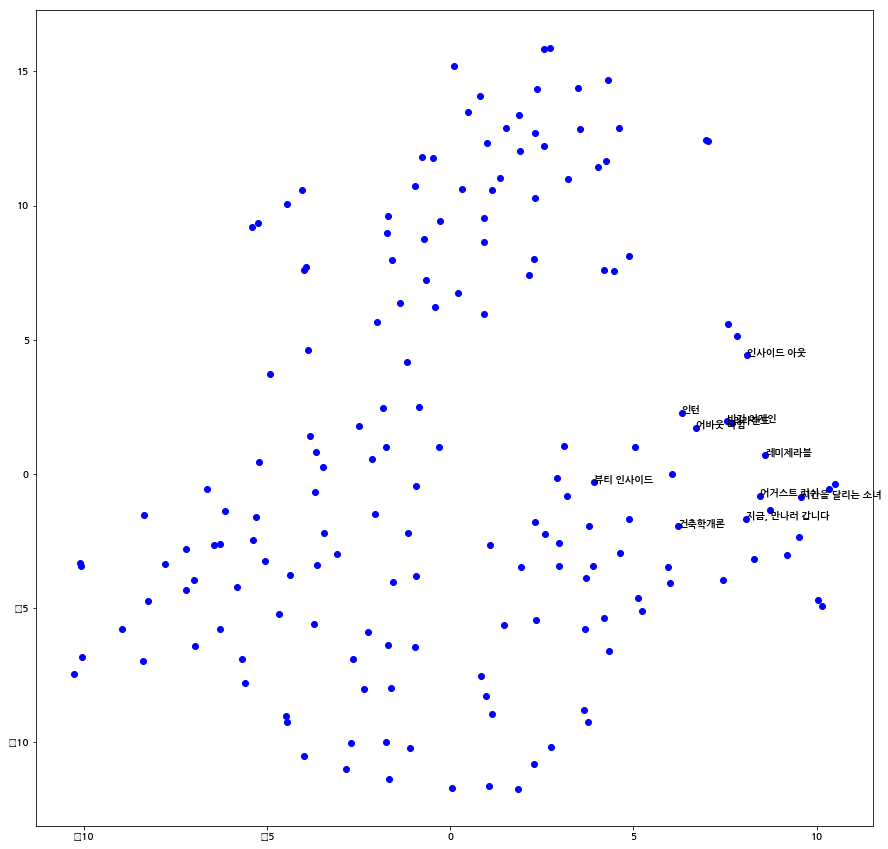

In [73]:
# print('134963 = ', idx2movie['134963'])

plt.figure(figsize=(15, 15))
plt.scatter(y_tsne[:, 0], y_tsne[:, 1], color = 'b')

similar = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_134963')] + ['MOVIE_134963']

for tag in similar:
    index = tag2index.get(tag, -1)
    if index == 1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))
    
plt.show()

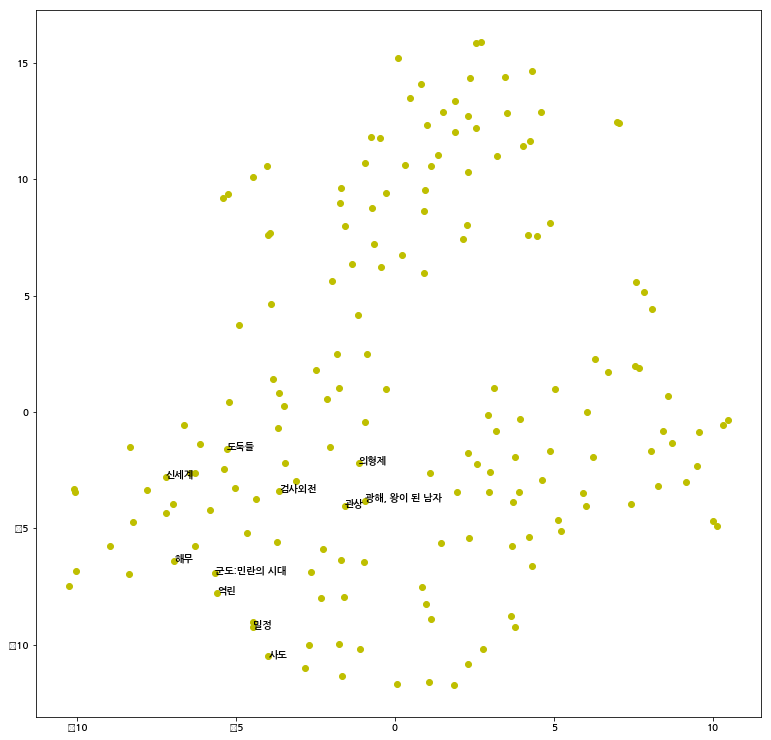

In [78]:
# print('93728 = ', idx2movie['93728'])

plt.figure(figsize=(13, 13))
plt.scatter(y_tsne[:, 0], y_tsne[:, 1], color = 'y')
 
similar = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_93728')] + ['MOVIE_93728']
for tag in similar:
    index = tag2index.get(tag, -1)
    if index == -1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))
        
plt.show()